# COMP4318/COMP5318 Assignment 2

### Chong Chen - 480076753  
### Zeyu Long  - 530666846

# Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make the notebook's output stable across runs
np.random.seed(42)

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Packages for running algorithms
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import accuracy_score

# The sklearnex is the Intel(R) Extension for Scikit-learn, this can speed up Scikit-learn application.
# The runtime for RandomForestClassifier and SVC are calculated with this extension patched.
# More information here: https://pypi.org/project/scikit-learn-intelex/#%F0%9F%9B%A0%20Installation
from sklearnex import patch_sklearn
patch_sklearn()

import warnings
warnings.filterwarnings("ignore")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Data loading, exploration, and preprocessing

## Data loading

In [3]:
# Load data files
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

## Data exploration

In [70]:
# Explore the input data size
print("X_train has ",X_train.shape[0], " rows of images")
print("X_test has ",X_test.shape[0], " rows of images")
print("Each image has shape of ", X_train.shape[1:3], " resolution with ", X_train.shape[3], " channels")
print("The overall X_train shape is: ", X_train.shape, "and the overall X_test shape is: ", X_test.shape)
print("The target has ", len(np.unique(y_train)), " classes")

X_train has  13673  rows of images
X_test has  3419  rows of images
Each image has shape of  (28, 28)  resolution with  3  channels
The overall X_train shape is:  (13673, 28, 28, 3) and the overall X_test shape is:  (3419, 28, 28, 3)
The target has  8  classes


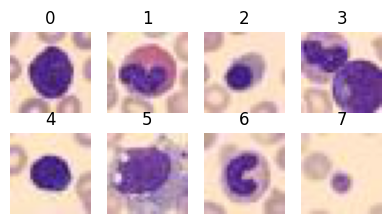

In [71]:
# Plot the first image for each class
plt.figure(figsize=(4 * 1.2, 2 * 1.2))
for i in range(8):
    for c in y_train:
        if c==i:
            index = np.where(y_train == c)[0][0]
            plt.subplot(2,4,i+1)
            plt.imshow(X_train[index])
            plt.title(i)
            plt.axis('off')
            break


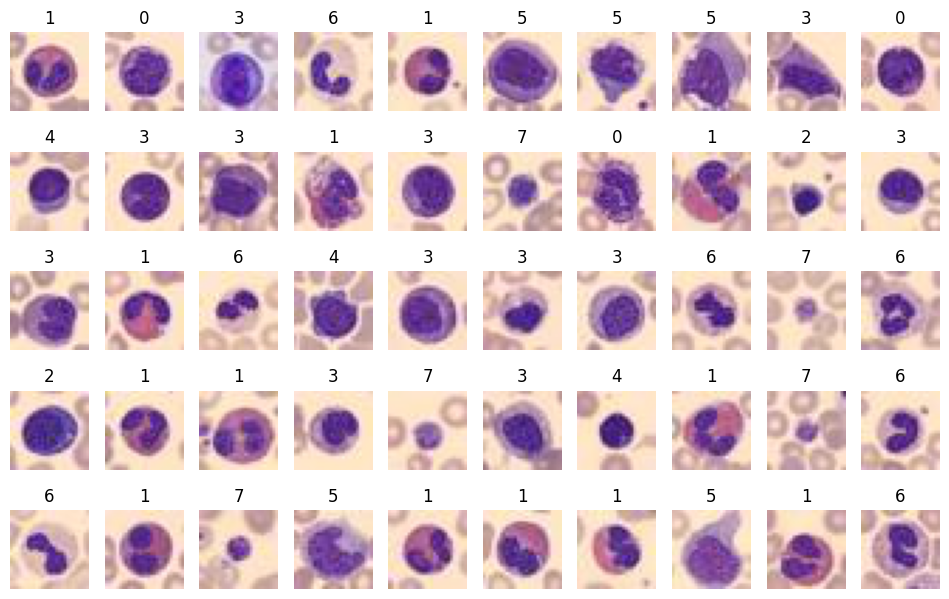

In [38]:
def plot_examples(data, n_rows=5, n_cols=10):

    # Set the gap size among images
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Set the index of image
            index = n_cols * row + col
            
            # Plot the image
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index])
            plt.title(y_test[index])
            plt.axis('off')
            
    plt.show()

plot_examples(X_test)

## Preprocessing

In [4]:
# Set a data augment function
def saturation_augmentation(image):
    image = tf.image.adjust_saturation(image, saturation_factor=3)
    image = tf.image.adjust_contrast(image, 2)
    image = tf.image.central_crop(image,1)
    return image

# Apply the data augment
X_train_sat = [saturation_augmentation(image) for image in X_train]
X_train_sat = np.array(X_train_sat)

X_test_sat = [saturation_augmentation(image) for image in X_test]
X_test_sat = np.array(X_test_sat)

# Normalize the data
X_train_sat = X_train_sat/255
X_test_sat = X_test_sat/255

# Reshape the data, make it flat
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalisation
X_train_flat = X_train_flat / 255
X_test_flat = X_test_flat / 255


## Examples of preprocessed data

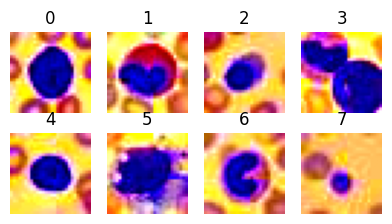

In [37]:
# Plot the image after preprocessed
plt.figure(figsize=(4 * 1.2, 2 * 1.2))
for i in range(8):
    for c in y_train:
        if c==i:
            index = np.where(y_train == c)[0][0]
            plt.subplot(2,4,i+1)
            plt.imshow(X_train_sat[index])
            plt.title(i)
            plt.axis('off')
            break

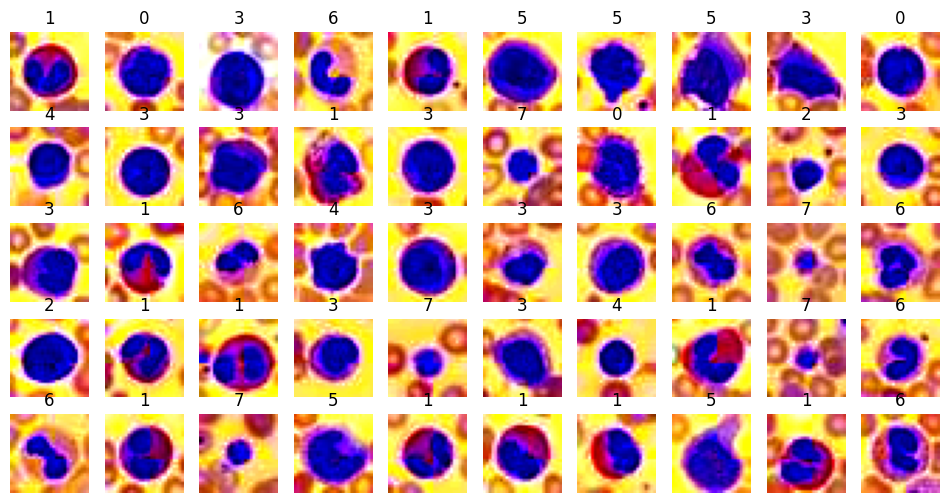

In [88]:
def plot_examples(data, n_rows=5, n_cols=10):
    # Set the gap size among images
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            # Set the index of image
            index = n_cols * row + col
            # Plot the image
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index])
            plt.title(y_test[index])
            plt.axis('off')
            
    plt.show()

plot_examples(X_test_sat)

# Algorithm design and setup

## Model 1 - Fully Connected Neural Network

In [20]:
# build the MLP model
MLP_model = keras.models.Sequential([
    # flatten the input images
    keras.layers.Flatten(input_shape=(28,28,3)),  
    
    # initialize the weight and bias
    keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),

    # more hidden layers
    keras.layers.Dense(512, activation='relu'),

    # set dropout for avoiding overfitting
    keras.layers.Dropout(0.5),

    # set output layer for 8 classes
    keras.layers.Dense(8, activation='softmax')
])

# declare the optimizer
opt1 = keras.optimizers.Adam(learning_rate=0.001)

# compile the model
MLP_model.compile(optimizer=opt1,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# train the model
MLP_model.fit(X_train_sat, y_train, epochs=30, batch_size=512, validation_data=(X_test_sat, y_test))

# evaluate the model
test_loss, test_accuracy = MLP_model.evaluate(X_test_sat, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/30
27/27 [==============================] - 1s 19ms/step - loss: 1.7086 - accuracy: 0.3669 - val_loss: 1.1099 - val_accuracy: 0.6247
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 1.0532 - accuracy: 0.6025 - val_loss: 0.8166 - val_accuracy: 0.6856
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.8841 - accuracy: 0.6611 - val_loss: 0.7326 - val_accuracy: 0.7151
Epoch 4/30
27/27 [==============================] - 0s 6ms/step - loss: 0.7872 - accuracy: 0.7034 - val_loss: 0.6615 - val_accuracy: 0.7403
Epoch 5/30
27/27 [==============================] - 0s 6ms/step - loss: 0.7039 - accuracy: 0.7363 - val_loss: 0.6177 - val_accuracy: 0.7575
Epoch 6/30
27/27 [==============================] - 0s 6ms/step - loss: 0.7100 - accuracy: 0.7345 - val_loss: 0.5872 - val_accuracy: 0.7686
Epoch 7/30
27/27 [==============================] - 0s 6ms/step - loss: 0.6411 - accuracy: 0.7616 - val_loss: 0.5732 - val_accuracy: 0.7795
Epoch 8/30
27/27 [=

## Model 2 - Convolutional Neural Network

In [7]:
CNN_model = keras.Sequential([
    # initialize input shape
    keras.Input(shape=(28, 28, 3)),

    # add convolutional layer and pooling layer
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    keras.layers.Flatten(),

    # add fully connected layer
    keras.layers.Dense(2048, activation="relu"),
    keras.layers.Dropout(0.5),

    # keras.layers.Dense(2048, activation="relu"),
    # keras.layers.Dropout(0.5),

    # add output layer
    keras.layers.Dense(8, activation="softmax")
])
opt1 = keras.optimizers.Adam(learning_rate=0.001)
CNN_model.compile(loss='sparse_categorical_crossentropy',
            optimizer=opt1,
              metrics=['accuracy'])

In [8]:
CNN_model.fit(X_train_sat, y_train, epochs=15, batch_size=128, validation_data=(X_test_sat, y_test))

test_loss, test_acc = CNN_model.evaluate(X_test_sat, y_test)
print(f'\nTest accuracy: {test_acc* 100:.2f}%')

Epoch 1/15
107/107 [==============================] - 2s 13ms/step - loss: 1.1539 - accuracy: 0.5955 - val_loss: 0.5243 - val_accuracy: 0.8020
Epoch 2/15
107/107 [==============================] - 1s 12ms/step - loss: 0.4682 - accuracy: 0.8299 - val_loss: 0.3635 - val_accuracy: 0.8698
Epoch 3/15
107/107 [==============================] - 1s 12ms/step - loss: 0.3500 - accuracy: 0.8746 - val_loss: 0.3408 - val_accuracy: 0.8818
Epoch 4/15
107/107 [==============================] - 1s 11ms/step - loss: 0.3131 - accuracy: 0.8857 - val_loss: 0.3014 - val_accuracy: 0.8927
Epoch 5/15
107/107 [==============================] - 1s 12ms/step - loss: 0.2559 - accuracy: 0.9079 - val_loss: 0.3127 - val_accuracy: 0.8894
Epoch 6/15
107/107 [==============================] - 1s 12ms/step - loss: 0.2104 - accuracy: 0.9247 - val_loss: 0.2860 - val_accuracy: 0.8994
Epoch 7/15
107/107 [==============================] - 1s 12ms/step - loss: 0.1866 - accuracy: 0.9329 - val_loss: 0.3270 - val_accuracy: 0.8906

## Model 3 - Random Forest

In [ ]:
# base model
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train_flat, y_train)
rfc_accuracy = accuracy_score(y_test, rfc.predict(X_test_flat))
print("Random Forest Classifier accuracy: {:.4f}".format(rfc_accuracy))

Random Forest Classifier accuracy: 0.8359


## Model 4 - SVM

In [ ]:
# base model (uses rbf kernel by default)
svm = SVC(random_state=42)
svm.fit(X_train_flat, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test_flat))
print("SVM Accuracy: {:.4f}".format(svm_accuracy))

SVM Accuracy: 0.8622


# Hyperparameter tuning

## Model 1 - Fully Connected Neural Network

In [4]:
def build_mlp(
    n_hidden_layers=2, n_hidden_neurons=128,
    activation_function="relu", input_shape=(28,28,3)
):

    # initialize the keras model
    model = keras.models.Sequential()

    # add the input layer
    model.add(keras.Input(shape=input_shape))
    model.add(keras.layers.Flatten())

    # initialize the first hidden layer
    model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function, kernel_initializer='he_normal', bias_initializer='zeros'))

    # add the hidden layers with customization
    for layer in range(n_hidden_layers):
        n_hidden_neurons = n_hidden_neurons/2
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
 
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(8, activation="softmax"))
    
    return model

In [5]:
# set up kerasClassifier with default hyperparameter values
mlp_classifier = KerasClassifier(build_mlp,
                                   n_hidden_layers=2,
                                   n_hidden_neurons=50,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="adam",
                                   optimizer__lr=0.01,
                                   batch_size=128,
                                   epochs=15,
                                   verbose=0,
                                   metrics=["accuracy"]
                                  )

In [26]:
warnings.filterwarnings("ignore")
# set up the hyperparameter dictionary
param_grid = {
    "n_hidden_layers": [2,3,4],
    "n_hidden_neurons": [512,1024],
    "optimizer__lr": [0.01,0.001],
    "batch_size": [256,512],
    "epochs": [30,40],
    "activation_function": ["relu","tanh"]
}

# implement the grid search for tuning
grid_search_mlp = GridSearchCV(mlp_classifier, param_grid, cv=3, verbose=0)
grid_search_mlp.fit(X_train_sat, y_train)

# print out the result
print(grid_search_mlp.score(X_test_sat, y_test))
print(grid_search_mlp.best_params_)


0.8704299502778591
{'activation_function': 'relu', 'batch_size': 512, 'epochs': 40, 'n_hidden_layers': 2, 'n_hidden_neurons': 1024, 'optimizer__lr': 0.001}


In [30]:
mlp_result_df = pd.DataFrame(grid_search_mlp.cv_results_)
mlp_result_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation_function,param_batch_size,param_epochs,param_n_hidden_layers,param_n_hidden_neurons,param_optimizer__lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.417857,0.275889,0.140149,0.009010,relu,256,30,2,512,0.01,"{'activation_function': 'relu', 'batch_size': ...",0.799473,0.773366,0.801843,0.791561,0.012902,58
1,3.209484,0.075653,0.137085,0.012001,relu,256,30,2,512,0.001,"{'activation_function': 'relu', 'batch_size': ...",0.854322,0.840061,0.818302,0.837562,0.014811,33
2,3.361798,0.151879,0.136636,0.008633,relu,256,30,2,1024,0.01,"{'activation_function': 'relu', 'batch_size': ...",0.805397,0.789601,0.830371,0.808456,0.016784,54
3,3.098253,0.047082,0.127683,0.003015,relu,256,30,2,1024,0.001,"{'activation_function': 'relu', 'batch_size': ...",0.856735,0.850373,0.843757,0.850288,0.005299,7
4,3.149114,0.028048,0.132330,0.001120,relu,256,30,3,512,0.01,"{'activation_function': 'relu', 'batch_size': ...",0.758447,0.775340,0.194646,0.576144,0.269848,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2.975380,0.144356,0.119778,0.001518,tanh,512,40,3,1024,0.001,"{'activation_function': 'tanh', 'batch_size': ...",0.842475,0.831505,0.833443,0.835808,0.004780,34
92,2.858806,0.014782,0.124999,0.001787,tanh,512,40,4,512,0.01,"{'activation_function': 'tanh', 'batch_size': ...",0.194822,0.194822,0.194646,0.194763,0.000083,72
93,2.856725,0.032530,0.125641,0.003129,tanh,512,40,4,512,0.001,"{'activation_function': 'tanh', 'batch_size': ...",0.849715,0.818341,0.849462,0.839173,0.014730,28
94,3.007718,0.006003,0.124704,0.001806,tanh,512,40,4,1024,0.01,"{'activation_function': 'tanh', 'batch_size': ...",0.194822,0.182317,0.194646,0.190595,0.005854,79


In [33]:

mlp_result = mlp_result_df[['rank_test_score',
                            'mean_fit_time',
                            'param_activation_function',
                            'param_batch_size','param_epochs',
                            'param_n_hidden_layers',
                            'param_n_hidden_neurons',
                            'param_optimizer__lr',
                            'mean_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)
mlp_result.head(10)

,rank_test_score,mean_fit_time,param_activation_function,param_batch_size,param_epochs,param_n_hidden_layers,param_n_hidden_neurons,param_optimizer__lr,mean_test_score
0,1,3.020689,relu,512,40,2,1024,0.001,0.855409
1,2,4.602350,tanh,256,40,2,1024,0.001,0.854312
2,3,4.775848,relu,256,40,2,1024,0.001,0.853360
3,4,3.079220,relu,512,40,2,512,0.001,0.852045
4,5,4.653455,relu,256,40,2,512,0.001,0.851094
5,6,2.342025,tanh,512,30,2,512,0.001,0.850435
6,7,3.098253,relu,256,30,2,1024,0.001,0.850288
7,8,4.157137,tanh,256,40,2,512,0.001,0.849778
8,9,2.764432,tanh,512,40,3,512,0.001,0.848607
9,10,5.219474,relu,256,40,3,512,0.001,0.848022


## Model 2 - Convolutional Neural Network

In [36]:
def build_CNN(
    n_convolutional_layers=2, n_filters=64, kernel_size=(3,3), pool_size=(2,2), n_fully_connected_neurons = 64,
    activation_function="relu", input_shape=(28,28,3)
):
    
    # Add the input layer
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    
    # Add first group of convolutional layer and pooling layer
    model.add(keras.layers.Conv2D(n_filters, kernel_size, activation=activation_function, padding='same'))
    model.add(keras.layers.Conv2D(n_filters, kernel_size, activation=activation_function, padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size))
    
    
    
    # Add the hidden layers with customization
    for layer in range(n_convolutional_layers-1):
        n_filters = n_filters*2
        model.add(keras.layers.Conv2D(n_filters,kernel_size, activation=activation_function, padding='same'))
        model.add(keras.layers.Conv2D(n_filters,kernel_size, activation=activation_function, padding='same'))
        model.add(keras.layers.MaxPooling2D(pool_size))
         
    # Flatten the result
    model.add(keras.layers.Flatten())
    
    # Add two fully connected layers
    model.add(keras.layers.Dense(n_fully_connected_neurons, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(n_fully_connected_neurons, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # Add the output layer for 8 class classification
    model.add(keras.layers.Dense(8, activation="softmax"))
    
    return model

In [43]:
# Create the CNN classifier for grid search
cnn_classifier = KerasClassifier(build_CNN,
                                   n_convolutional_layers=2,
                                   n_filters=64,
                                   kernel_size=(3,3),
                                   pool_size=(2,2),
                                   n_fully_connected_neurons=64,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="adam",
                                   optimizer__lr=0.01,
                                   batch_size=128,
                                   epochs=15,
                                   verbose=0,
                                   metrics=["accuracy"]
                                  )

In [50]:
# Define the parameter dictionary for tuning
param_grid = {
    "n_convolutional_layers": [2,3,4],
    "n_filters": [32,64],
    "n_fully_connected_neurons": [1024,2048],
    "optimizer__lr": [0.01,0.001],
    "batch_size": [256,512],
    "epochs": [15,20],
    "activation_function": ["relu","tanh", "sigmoid"]
}

# Implement the grid search
grid_search_cnn = RandomizedSearchCV(cnn_classifier, param_grid, cv=3, verbose=0)
grid_search_cnn.fit(X_train_sat, y_train)

# Print the best combination and score
print(grid_search_cnn.score(X_test_sat, y_test))
print(grid_search_cnn.best_params_)


0.9160573267037145
{'optimizer__lr': 0.001, 'n_fully_connected_neurons': 1024, 'n_filters': 64, 'n_convolutional_layers': 2, 'epochs': 20, 'batch_size': 512, 'activation_function': 'relu'}


In [51]:
# Load the result dataframe
cnn_result_df = pd.DataFrame(grid_search_cnn.cv_results_)

In [52]:
# Refine the usefule information
cnn_result = cnn_result_df[['rank_test_score',
                            'mean_fit_time',
                            'param_n_fully_connected_neurons',
                            'param_n_filters',
                            'param_n_convolutional_layers',
                            'param_activation_function',
                            'param_batch_size',
                            'param_epochs',
                            'param_optimizer__lr',
                            'mean_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)
cnn_result.head(10)

,rank_test_score,mean_fit_time,param_n_fully_connected_neurons,param_n_filters,param_n_convolutional_layers,param_activation_function,param_batch_size,param_epochs,param_optimizer__lr,mean_test_score
0,1,13.836229,1024,64,2,relu,512,20,0.001,0.901266
1,2,23.153002,1024,64,4,relu,256,20,0.001,0.898924
2,3,19.482323,1024,64,3,tanh,512,20,0.001,0.889930
3,4,7.357376,1024,32,3,relu,256,15,0.001,0.887224
4,5,14.735374,1024,64,3,tanh,512,15,0.001,0.884517
5,6,7.983814,1024,32,4,sigmoid,512,15,0.01,0.194763
6,6,11.433093,2048,32,4,relu,256,20,0.01,0.194763
7,6,23.011941,2048,64,4,relu,256,20,0.01,0.194763
8,6,14.056819,1024,64,2,tanh,512,20,0.01,0.194763
9,6,7.334804,2048,32,2,sigmoid,256,15,0.001,0.194763


In [53]:
warnings.filterwarnings("default")

## Model 3 - Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [128, 256, 512, 640],
    'min_samples_split': [2, 6, 10]
}

grid_search_rf = GridSearchCV(estimator=rfc,
                               param_grid=param_grid,
                               scoring='accuracy',
                               cv=3, n_jobs=4)

grid_search_rf.fit(X_train_flat, y_train)

best_params = grid_search_rf.best_params_
print('Best hyperparameter combination: {}'.format(best_params))

best_cv_score = grid_search_rf.best_score_
print("Best CV score: {:.4f}".format(best_cv_score))

test_score = grid_search_rf.score(X_test_flat, y_test)
print("Best model's test set accuracy score: {:.4f}".format(test_score))

Best hyperparameter combination: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 640}
Best CV score: 0.8365
Best model's test set accuracy score: 0.8473


In [ ]:
rf_result_df = pd.DataFrame(grid_search_rf.cv_results_)
rf_result = rf_result_df[['rank_test_score',
                          'param_criterion',
                          'param_min_samples_split',
                          'param_n_estimators',
                          'mean_fit_time',
                          'mean_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)
rf_result

,rank_test_score,param_criterion,param_min_samples_split,param_n_estimators,mean_fit_time,mean_test_score
0,1,entropy,2,640,169.035754,0.836466
1,2,entropy,2,512,138.142739,0.835881
2,3,gini,6,640,41.644914,0.833907
3,4,entropy,6,512,159.329389,0.833614
4,5,gini,2,256,32.298254,0.833395
5,6,gini,2,512,39.916871,0.833322
6,7,gini,10,512,32.344464,0.833321
7,8,entropy,6,640,190.841746,0.833321
8,9,entropy,2,256,67.834845,0.832810
9,10,entropy,6,256,67.116765,0.832663


## Model 4 - SVM

In [ ]:
# define models
svm_linear = SVC(kernel='linear', random_state=42)
svm_poly = SVC(kernel='poly', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_sigmoid = SVC(kernel='linear', random_state=42)

# fit models
svm_linear.fit(X_train_flat, y_train)
svm_poly.fit(X_train_flat, y_train)
svm_rbf.fit(X_train_flat, y_train)
svm_sigmoid.fit(X_train_flat, y_train)

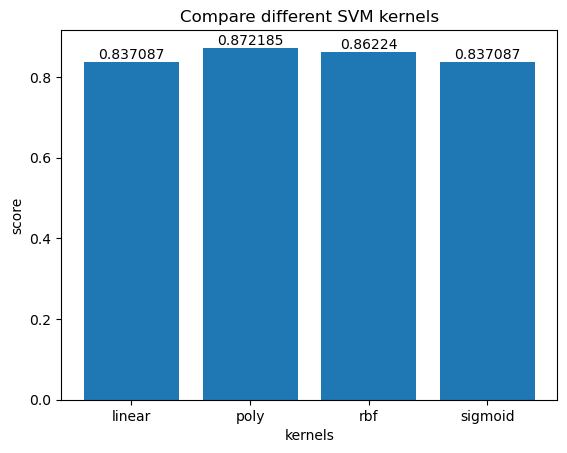

In [ ]:
# comparing 4 different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
scores = []
# score
scores.append(accuracy_score(y_test, svm_linear.predict(X_test_flat))) 
scores.append(accuracy_score(y_test, svm_poly.predict(X_test_flat))) 
scores.append(accuracy_score(y_test, svm_rbf.predict(X_test_flat)))
scores.append(accuracy_score(y_test, svm_sigmoid.predict(X_test_flat)))

# plot their score
bars = plt.bar(kernels, scores)
plt.bar_label(bars)
plt.xlabel('kernels')
plt.ylabel('score')
plt.title('Compare different SVM kernels')
plt.show()

In [ ]:
# the best 2 out of 4 kernels selected, and run seperate grid search
svm_rbf = SVC(kernel='rbf', random_state=42)
param_grid_rbf = {
    'C': [6, 8, 10],
    'gamma': [0.010, 0.012, 0.014, 'scale']
}
grid_search_svm_rbf = GridSearchCV(estimator=svm_rbf,
                               param_grid=param_grid_rbf,
                               scoring='accuracy',
                               cv=3, n_jobs=4)
grid_search_svm_rbf.fit(X_train_flat, y_train)


svm_poly = SVC(kernel='poly', random_state=42)
param_grid_poly = {
    'C': [6, 8, 10],
    'gamma': [0.008, 0.010, 0.012, 'scale'],
    'degree': [3, 4, 5]
}
grid_search_svm_poly = GridSearchCV(estimator=svm_poly,
                               param_grid=param_grid_poly,
                               scoring='accuracy',
                               cv=3, n_jobs=4)
grid_search_svm_poly.fit(X_train_flat, y_train)

In [ ]:
print("rbf kernel:")
best_params_rbf = grid_search_svm_rbf.best_params_
print('Best hyperparameter combination rbf: {}'.format(best_params_rbf))

best_cv_score_rbf = grid_search_svm_rbf.best_score_
print("Best CV score rbf: {:.4f}".format(best_cv_score_rbf))

test_score_rbf = grid_search_svm_rbf.score(X_test_flat, y_test)
print("Best model's test set accuracy score rbf: {:.4f}".format(test_score_rbf))

print()
print("poly kernel:")
best_params_poly = grid_search_svm_poly.best_params_
print('Best hyperparameter combination poly: {}'.format(best_params_poly))

best_cv_score_poly = grid_search_svm_poly.best_score_
print("Best CV score poly: {:.4f}".format(best_cv_score_poly))

test_score_poly = grid_search_svm_poly.score(X_test_flat, y_test)
print("Best model's test set accuracy score poly: {:.4f}".format(test_score_poly))

rbf kernel:
Best hyperparameter combination rbf: {'C': 8, 'gamma': 0.012}
Best CV score rbf: 0.8765
Best model's test set accuracy score rbf: 0.8997

poly kernel:
Best hyperparameter combination poly: {'C': 6, 'degree': 5, 'gamma': 0.008}
Best CV score poly: 0.8561
Best model's test set accuracy score poly: 0.8813


In [ ]:
svm_result_df = pd.DataFrame(grid_search_svm_rbf.cv_results_)
svm_result = svm_result_df[['rank_test_score',
                            'param_C',
                            'param_gamma',
                            'mean_fit_time',
                            'mean_test_score']].sort_values(by='rank_test_score', ascending=True).reset_index(drop=True)

svm_result

,rank_test_score,param_C,param_gamma,mean_fit_time,mean_test_score
0,1,8,0.012,27.644372,0.876472
1,2,8,0.014,30.818214,0.876252
2,3,10,0.012,29.459849,0.876106
3,4,10,0.014,26.594514,0.875814
4,5,10,0.01,29.359450,0.875740
5,6,6,0.014,29.930921,0.875667
6,7,6,0.01,29.959845,0.875521
7,8,10,scale,29.238108,0.875375
8,9,6,scale,30.771009,0.875229
9,10,6,0.012,30.829185,0.875009


# Final Models

## Model 1 - Fully Connected Neural Network

In [24]:
# build the MLP model
MLP_model = keras.models.Sequential([
    # Flatten the input images
    keras.layers.Flatten(input_shape=(28,28,3)),  

    # initialize the weight and bias
    keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),

    # dropout for decreasing the risk of overfitting
    keras.layers.Dropout(0.5), 

    # output layer
    keras.layers.Dense(8, activation='softmax')  
])

# initialize the optimizer function
opt1 = keras.optimizers.Adam(learning_rate=0.001)

# compile the model
MLP_model.compile(optimizer=opt1,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
# train the model
MLP_model.fit(X_train_sat, y_train, epochs=40, batch_size=512, validation_data=(X_test_sat, y_test))

# evaluate the model
test_loss, test_accuracy = MLP_model.evaluate(X_test_sat, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/40
27/27 [==============================] - 1s 17ms/step - loss: 1.6115 - accuracy: 0.4109 - val_loss: 1.1011 - val_accuracy: 0.6133
Epoch 2/40
27/27 [==============================] - 0s 6ms/step - loss: 1.0382 - accuracy: 0.6024 - val_loss: 0.8184 - val_accuracy: 0.6970
Epoch 3/40
27/27 [==============================] - 0s 6ms/step - loss: 0.8549 - accuracy: 0.6721 - val_loss: 0.6961 - val_accuracy: 0.7303
Epoch 4/40
27/27 [==============================] - 0s 5ms/step - loss: 0.7694 - accuracy: 0.7091 - val_loss: 0.6582 - val_accuracy: 0.7374
Epoch 5/40
27/27 [==============================] - 0s 6ms/step - loss: 0.7078 - accuracy: 0.7349 - val_loss: 0.6336 - val_accuracy: 0.7455
Epoch 6/40
27/27 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.7461 - val_loss: 0.6013 - val_accuracy: 0.7669
Epoch 7/40
27/27 [==============================] - 0s 6ms/step - loss: 0.6333 - accuracy: 0.7660 - val_loss: 0.5929 - val_accuracy: 0.7783
Epoch 8/40
27/27 [=

## Model 2 - Convolutional Neural Network

In [57]:
CNN_model = keras.Sequential([
    keras.Input(shape=(28, 28, 3)),

    # add convolutional layer with size 3x3
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    # add maxPooing layer with size 2x2
    keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), strides=(2,2)),
    
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), strides=(2,2)),

    # faltten the result from Conv2D and Pooling2D
    keras.layers.Flatten(),

    # add two fully connected layers
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dropout(0.5),

    # add output layer with 8 neurones
    keras.layers.Dense(8, activation="softmax")
])

opt1 = keras.optimizers.Adam(learning_rate=0.001)
CNN_model.compile(loss='sparse_categorical_crossentropy',
            optimizer=opt1,
              metrics=['accuracy'])

In [58]:
# fit the model
CNN_model.fit(X_train_sat, y_train, epochs=20, batch_size=512, validation_data=(X_test_sat, y_test))

test_loss, test_acc = CNN_model.evaluate(X_test_sat, y_test)
print(f'\nTest accuracy: {test_acc* 100:.2f}%')

Epoch 1/20
27/27 [==============================] - 3s 60ms/step - loss: 1.8454 - accuracy: 0.2630 - val_loss: 1.4885 - val_accuracy: 0.4323
Epoch 2/20
27/27 [==============================] - 1s 55ms/step - loss: 1.3322 - accuracy: 0.4607 - val_loss: 1.1472 - val_accuracy: 0.5645
Epoch 3/20
27/27 [==============================] - 1s 55ms/step - loss: 0.9165 - accuracy: 0.6375 - val_loss: 0.6948 - val_accuracy: 0.7201
Epoch 4/20
27/27 [==============================] - 1s 55ms/step - loss: 0.6961 - accuracy: 0.7227 - val_loss: 0.6023 - val_accuracy: 0.7567
Epoch 5/20
27/27 [==============================] - 1s 55ms/step - loss: 0.6457 - accuracy: 0.7447 - val_loss: 0.5685 - val_accuracy: 0.7669
Epoch 6/20
27/27 [==============================] - 1s 55ms/step - loss: 0.5438 - accuracy: 0.7814 - val_loss: 0.4915 - val_accuracy: 0.8037
Epoch 7/20
27/27 [==============================] - 1s 55ms/step - loss: 0.5502 - accuracy: 0.7902 - val_loss: 0.5133 - val_accuracy: 0.8017
Epoch 8/20
27

## Model 3 - Random Forest

In [ ]:
rfc = RandomForestClassifier(criterion='entropy', min_samples_split=2, n_estimators=640, random_state=42, n_jobs=-1)
rfc.fit(X_train_flat, y_train)
rfc_accuracy = accuracy_score(y_test, rfc.predict(X_test_flat))
print("Best Random Forest Classifier accuracy: {:.4f}".format(rfc_accuracy))

Best Random Forest Classifier accuracy: 0.8473


## Model 4 - SVM

In [ ]:
svm = SVC(kernel='rbf', C=8, gamma=0.012, random_state=42)
svm.fit(X_train_flat, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test_flat))
print("Best SVM Accuracy: {:.4f}".format(svm_accuracy))

Best SVM Accuracy: 0.8997
